In [1]:
import bisect
# go to the parent folder
import os

import matplotlib.pyplot as plt

os.chdir("..")

import numpy as np
import pandas as pd
import time

# Our package
from RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification

In this example, we consider a three gene-state model as follows:
\begin{align}
&\text{Gene Activation:} && G \to G^* && \text{Propensity:} ~ k_{1} X_G \\
&\text{Gene Deactivation:} && G^* \to G && \text{Propensity:} ~ k_{2} X_{G^*} \\
&\text{Gene Further activation:} && G^* \to G^{**} && \text{Propensity:} ~ k_3 X_{G^*} \\
&\text{Gene Deactivation:} && G^{**} \to G^* && \text{Propensity:} ~ k_4 X_{G^{**}} \\
&\text{mRNA Transcription:} && \emptyset \to \text{mRNA} && \text{Propensity:} ~ k_{p1} （X_{G^*} +X_{G^{**}}) + k_{p2} X_{G^{**}}  \\
&\text{mRNA Degration:} &&\text{mRNA} \to \emptyset && \text{Propensity:} ~ k_d X_\text{mRNA} \\
\end{align}
the gene can transition between three distinct states, with mRNA being produced when the gene is in either of the two activated states. Additionally, the rate of mRNA degradation is directly proportional to its copy number. Also, we assume that the mRNA exhibits fluorescence, allowing for the use of a microscope to record its dynamics very 2 minutes. Here, we set $k_d = 1$

The system in this example is the same as the previous one. However, the numbers are choice of parameters are diffent.

leader species:  ['G1', 'G2']
follower species:  ['mRNA', 'G0']
follower parameters:  ['sigma', 'k3', 'k2', 'kp1', 'k4', 'k1', 'kp2']


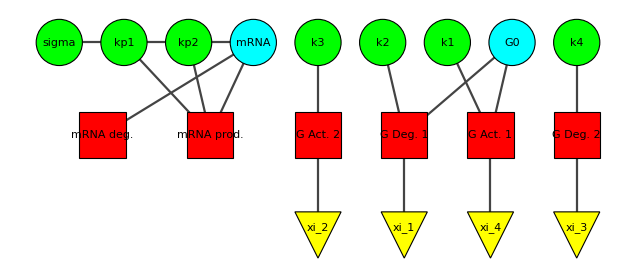

Number of subsystems: 4
-----------------------------------------------------
    xi_1  xi_2  xi_3  xi_4
G1    -1    -1     1     1
G2     0     1    -1     0
-----------------------------------------------------
Subsystem:  1
Involved parameters and species: ['sigma', 'kp1', 'kp2', 'mRNA']
Unobservable reactions involved: ['mRNA deg.', 'mRNA prod.']
Observable reactions involved: []
Xi involved: []
Size of state space of this subsystem: 21000
-----------------------------------------------------
Subsystem:  2
Involved parameters and species: ['k3']
Unobservable reactions involved: []
Observable reactions involved: ['G Act. 2']
Xi involved: ['xi_2']
Size of state space of this subsystem: 21
-----------------------------------------------------
Subsystem:  3
Involved parameters and species: ['k2', 'k1', 'G0']
Unobservable reactions involved: []
Observable reactions involved: ['G Deg. 1', 'G Act. 1']
Xi involved: ['xi_1', 'xi_4']
Size of state space of this subsystem: 882
---------------

In [2]:
# The network structure
species_names = ['G0', 'G1', 'G2', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0, 0, 0],
                         [1, -1, -1, 1, 0, 0],
                         [0, 0, 1,-1, 0, 0],
                         [0, 0, 0, 0, 1,-1]]
parameters_names = ['k1','k2', 'k3', 'k4', 'kp1', 'kp2', 'sigma']
reaction_names = ['G Act. 1', 'G Deg. 1', 'G Act. 2', 'G Deg. 2', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda k3, G1: k3*G1,
    lambda k4, G2: k4*G2,
    lambda kp1, kp2, G1, G2: kp1*(G1+G2) + kp2*G2,
    lambda mRNA: 1*mRNA
]

range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 1], [0, 20] ], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [1, 10], [0.1, 1]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 21, 21, 10, 10, 10], index=parameters_names) #index=parameters_names

# The observation related information
# h_function = [
#     lambda Protein: Protein
# ]
h_function = [
    lambda mRNA: mRNA
]
observation_noise_intensity = [
    # lambda : 0.1
    lambda sigma: sigma
]
#observation_noise_intensity = {'sigma1': 0.1}

maximum_size_of_each_follower_subsystem = 30000 #800 #10000 # 1000


MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function,
    maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

print('leader species: ', MI.leader_species_time_course_data)
print('follower species: ', MI.get_follower_species_time_course_data())
print('follower parameters: ', MI.get_follower_parameters_time_course_data())
MI.leader_follower_decomposition_result_time_course_data.plot_decomposition()

In [3]:
# load data

import pickle

real_sigma = 0.1

file_name = 'Example_of_model_identification/results_in_paper/data_example_4_tf_480_particle_number_3000_sigma_0'+ str(int(real_sigma*10)) +'.pkl'

# Load the objects from the pickle file
with open(file_name, 'rb') as f:
    data = pickle.load(f)


# Create a new object from the dictionary
Marginal_distributions_over_time = data['margin_distributions_over_time']
time_result = data['time_result']
mean_result = data['mean_result']
std_result = data['std_result']
parameter_values = data['parameter_values']
real_sigma = data['real_sigam']

Y_list = data['Y_list']
time_list = data['time_list']
state_list = data['state_list']
Observation_times_list = data['Observation_times_list']

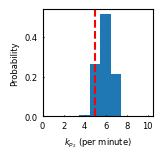

In [4]:
# the prameter estimation result

def cm_to_inch(value):
    return value/2.54

parameter_species_names = MI.parameters_names + MI.species_names
marginal_distributions = sorted(Marginal_distributions_over_time[-1], key=lambda x: parameter_species_names.index(next(iter(x.parameter_species_ordering))))


# something to change for different plot
marginal_distribution = marginal_distributions[5]
name_to_show = '$k_{p_2}$'


distribution = marginal_distribution.distribution_list[-1].copy()
states = marginal_distribution.states.copy()
name = list(marginal_distribution.parameter_species_ordering.keys())[0]


fig = plt.figure(figsize=(cm_to_inch(4), cm_to_inch(4)))

plt.bar(states.reshape(-1), distribution.reshape(-1), width=states[1] - states[0], label='Estimated distribution')
plt.axvline(x=parameter_values[name], color='r', linestyle='--', label='real value')


if name == 'sigma':
    plt.xlabel(name_to_show, fontsize=6)
else:
    plt.xlabel(name_to_show +' (per minute)', fontsize=6)
plt.ylabel('Probability', fontsize=6)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

if name in ['k1']:
    xticks = np.arange(0, 1.1, step=0.2)
    plt.xlim((0-0.025, 1+0.025))
    yticks = np.arange(0, 0.41, step=0.2)
    #yticks = np.arange(0, 0.91, step=0.3)
elif name == 'k2':
    xticks = np.arange(0, 1.1, step=0.2)
    plt.xlim((0-0.025, 1+0.025))
    yticks = np.arange(0, 0.11, step=0.1)
elif name == 'k3':
    xticks = np.arange(0, 1.1, step=0.2)
    plt.xlim((0-0.025, 1+0.025))
    yticks = np.arange(0, 0.21, step=0.1)
elif name == 'k4':
    xticks = np.arange(0, 1.1, step=0.2)
    plt.xlim((0-0.025, 1+0.025))
    yticks = np.arange(0, 0.21, step=0.1)
elif name == 'sigma':
    xticks = np.arange(0, 1.1, step=0.2)
    plt.xlim((0, 1+0.025))
    yticks = np.arange(0, 1.1, step=0.5)
elif name == 'kp1':
    xticks = np.arange(0, 11, step=2)
    plt.xlim((1-0.5, 10+0.5))
    #yticks = np.arange(0, 0.61, step=0.2)
    yticks = np.arange(0, 0.41, step=0.2)
else:
    xticks = np.arange(0, 11, step=2)
    plt.xlim((1-0.5, 10+0.5))
    #yticks = np.arange(0, 0.61, step=0.2)
    yticks = np.arange(0, 0.41, step=0.2)


plt.xticks(xticks)  # Set the x-ticks
plt.yticks(yticks)  # Set the x-ticks




# plt.legend(loc='upper left', fontsize=6)



plt.subplots_adjust(bottom=0.2, left= 0.2)



fig.savefig("figure.eps", format='eps')

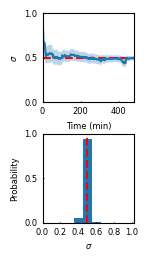

In [6]:
# plot the final estimation result and convergence for different sigma values.

import pickle

real_sigma = 0.5

file_name = 'Example_of_model_identification/results_in_paper/data_example_4_tf_480_particle_number_3000_sigma_0'+ str(int(real_sigma*10)) +'.pkl'

# Load the objects from the pickle file
with open(file_name, 'rb') as f:
    data = pickle.load(f)


# Create a new object from the dictionary
Marginal_distributions_over_time = data['margin_distributions_over_time']
time_result = data['time_result']
mean_result = data['mean_result']
std_result = data['std_result']
parameter_values = data['parameter_values']
real_sigma = data['real_sigam']

Y_list = data['Y_list']
time_list = data['time_list']
state_list = data['state_list']
Observation_times_list = data['Observation_times_list']

def cm_to_inch(value):
    return value/2.54


marginal_distributions = sorted(Marginal_distributions_over_time[-1], key=lambda x: parameter_species_names.index(next(iter(x.parameter_species_ordering))))


# something to change for different plot
marginal_distribution = marginal_distributions[6]
name_to_show = '$\sigma$'


distribution = marginal_distribution.distribution_list[-1].copy()
states = marginal_distribution.states.copy()
name = list(marginal_distribution.parameter_species_ordering.keys())[0]



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(cm_to_inch(3), cm_to_inch(6.9)))
fig.subplots_adjust(hspace=cm_to_inch(0.9))


# plot the convergence result

time_result = np.insert(time_result, 0, 0)
mean_result['sigma'].insert(0, np.array([0.55]))
std_result['sigma'].insert(0, np.array([0.29]))

mean_out = np.array(mean_result['sigma']).reshape(-1)
std_out = np.array(std_result['sigma']).reshape(-1)


ax1.fill_between(time_result, mean_out-std_out, mean_out+std_out,alpha=0.3)
ax1.axhline(y=real_sigma, color='r', linestyle='--', label='real value')
ax1.plot(time_result, mean_out)


ax1.set_xlim([0, 30])
ax1.set_ylim([0, 1])

xticks = np.arange(0, 31, step=10)
plt.xlim((0-0.025, 1+0.025))
yticks = np.arange(0, 1.1, step=0.5)

if real_sigma > 0.2:
    xticks = np.arange(0, 481, step=200)
    ax1.set_xlim([0, 480])


ax1.set_xlabel('Time (min)', fontsize=6)
ax1.set_ylabel(name_to_show, fontsize=6)
ax1.tick_params(axis='x', labelsize=6, direction='in', length=1)
ax1.tick_params(axis='y', labelsize=6, direction='in', length=1)

ax1.set_xticks(xticks)  # Set the x-ticks
ax1.set_yticks(yticks)  # Set the x-ticks


# plot the final estimation result

ax2.bar(states.reshape(-1), distribution.reshape(-1), width=states[1] - states[0], label='Estimated distribution')
ax2.axvline(x=parameter_values[name], color='r', linestyle='--', label='real value')

xticks = np.arange(0, 1.1, step=0.2)
ax2.set_xlim((0, 1+0.025))
    #yticks = np.arange(0, 0.61, step=0.2)
yticks = np.arange(0, 1.1, step=0.5)

ax2.set_xticks(xticks)  # Set the x-ticks
ax2.set_yticks(yticks)  # Set the x-ticks
ax2.tick_params(axis='x', labelsize=6, direction='in', length=1)
ax2.tick_params(axis='y', labelsize=6, direction='in', length=1)

ax2.set_ylabel('Probability', fontsize=6)
ax2.set_xlabel(name_to_show, fontsize=6)


fig.savefig("figure.pdf", format='pdf')